In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import *
from keras import optimizers
from keras import regularizers


In [187]:
faces = fetch_lfw_people(min_faces_per_person=100)

In [188]:
faces.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [189]:
#dividing dataset
xtrain,xtest, ytrain,ytest = train_test_split(faces.data, faces.target, test_size=.25, random_state=0)

In [190]:
#printing shap of the data
print('Shape of xtrain :',xtrain.shape)
print('Shape of ytrain :',ytrain.shape)
print('Shape of xtest :',xtest.shape)
print('Shape of ytest :',ytest.shape)

Shape of xtrain : (855, 2914)
Shape of ytrain : (855,)
Shape of xtest : (285, 2914)
Shape of ytest : (285,)


In [191]:
#shape of images
faces.images.shape

(1140, 62, 47)

In [192]:
#Unique person
unique_classes = np.unique(ytrain)
n_classes = len(unique_classes)

print('Unique classes is :',unique_classes)
print('Number of unique classes :',n_classes)

Unique classes is : [0 1 2 3 4]
Number of unique classes : 5


# Visualizing some images

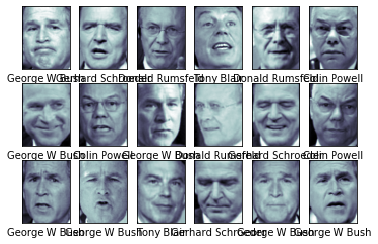

In [193]:
fig, ax = plt.subplots(3,6)
for i, axes in enumerate(ax.flat):
    axes.imshow(faces.images[i], cmap='bone')
    axes.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

# Encoding

In [194]:
ytrain_one_hot = to_categorical(ytrain)
ytest_one_hot = to_categorical(ytest)

print('Shape of ytrain_one_hot :',ytrain_one_hot.shape)
print('Shape of ytest_one_hot :',ytest_one_hot.shape)

Shape of ytrain_one_hot : (855, 5)
Shape of ytest_one_hot : (285, 5)


# Standardize

In [195]:
x_train = xtrain/255
x_test = xtest/255

# Reshape

In [196]:
x_train = x_train.reshape(-1,62,47,1)
x_test = x_test.reshape(-1,62,47,1)

# Model

In [197]:

model = Sequential()

model.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=(62, 47, 1)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same',activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(350, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))



In [198]:
#summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 58, 43, 16)        416       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 58, 43, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 29, 21, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 29, 21, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 29, 21, 64)        18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 29, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 10, 64)       

In [199]:
#compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ImageDataGenerator

In [200]:
#for train data
train_datagen = ImageDataGenerator(
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)


#for test data
test_datagen = ImageDataGenerator(
                                rescale=1./255)

In [201]:
model_fit = model.fit_generator(train_datagen.flow(x_train,ytrain_one_hot, batch_size=32), 
                    verbose=1, 
                    epochs=20,
                    )

Epoch 1/20
27/27 [==============================] - 8s 315ms/step - loss: 2.0732 - accuracy: 0.3368
Epoch 2/20
27/27 [==============================] - 6s 216ms/step - loss: 1.6355 - accuracy: 0.5345
Epoch 3/20
27/27 [==============================] - 6s 215ms/step - loss: 1.3773 - accuracy: 0.6070
Epoch 4/20
27/27 [==============================] - 6s 218ms/step - loss: 1.1079 - accuracy: 0.6877
Epoch 5/20
27/27 [==============================] - 6s 217ms/step - loss: 1.0328 - accuracy: 0.7298
Epoch 6/20
27/27 [==============================] - 6s 214ms/step - loss: 0.9540 - accuracy: 0.7322
Epoch 7/20
27/27 [==============================] - 6s 216ms/step - loss: 0.8040 - accuracy: 0.7860
Epoch 8/20
27/27 [==============================] - 6s 216ms/step - loss: 0.8178 - accuracy: 0.7930
Epoch 9/20
27/27 [==============================] - 6s 217ms/step - loss: 0.7219 - accuracy: 0.8281
Epoch 10/20
27/27 [==============================] - 6s 221ms/step - loss: 0.6585 - accuracy: 0.8561

# Accuracy and Loss curve

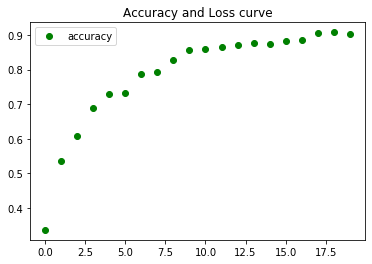

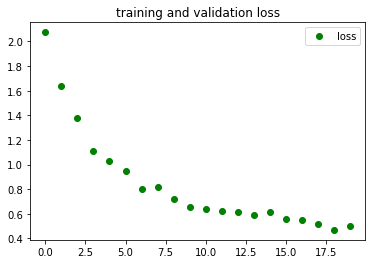

In [202]:
accuracy = model_fit.history['accuracy']
loss = model_fit.history['loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'go', label='accuracy')
plt.title('Accuracy and Loss curve')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# Predicting with test data

In [203]:
predicted = model.predict(x_test)
predicted = np.argmax(predicted, axis=1)

print('Predicted data :',predicted)
print('Shape of predicted data :',predicted.shape)

Predicted data : [0 4 2 0 2 2 4 4 2 2 4 4 1 4 2 0 2 2 2 2 3 4 2 1 0 2 2 4 2 2 0 4 0 2 0 2 2
 2 2 4 4 2 0 2 3 4 4 2 4 4 3 0 0 0 2 2 2 2 4 2 0 2 2 0 2 3 1 2 4 2 3 3 0 2
 2 2 2 3 4 4 3 2 0 0 0 4 2 1 0 4 4 4 4 0 2 2 0 2 4 2 2 2 1 0 0 4 2 2 2 0 1
 0 3 0 2 0 1 2 4 2 4 2 2 3 2 0 0 2 1 2 1 0 3 2 0 0 0 1 0 1 4 0 2 2 4 2 4 3
 2 4 2 2 2 2 0 0 4 2 2 0 2 2 2 2 0 3 1 0 0 2 2 2 0 0 4 2 4 3 3 4 1 2 4 2 0
 2 2 2 2 2 2 1 2 3 1 2 3 4 0 2 2 0 2 2 2 0 0 0 0 0 1 0 0 3 3 2 2 0 0 2 4 4
 4 1 0 0 0 2 2 2 2 2 4 2 3 0 2 0 0 2 0 4 4 1 0 4 0 2 2 1 2 1 3 4 2 2 0 2 0
 4 4 2 2 3 4 2 2 1 2 3 2 4 4 1 1 2 4 0 3 0 3 2 0 4 2]
Shape of predicted data : (285,)


# Confusion Matrix

Text(64.50000000000003, 0.5, 'Predicted data')

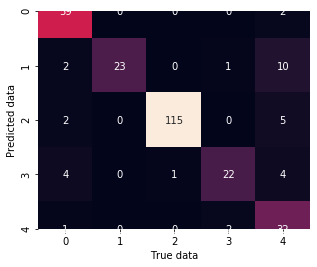

In [204]:
sns.heatmap(confusion_matrix(ytest, predicted), square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True data')
plt.ylabel('Predicted data')